# GHZ Decays

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ghzstate import GHZState
from utilities import startup
provider = startup(check=False)

Account enabled
Provider: ibm-q-melbourne


In [2]:
def lim_array(array):
    n_prev = 1
    for i, n in enumerate(array):
        if n > n_prev and (n_prev < 0.2 or n < 0.2):
            array[i:] = np.ones(len(array[i:])) * n_prev
            break
        n_prev = n
        
    return array

## DD vs no DD Test

In [21]:
backend = provider.get_backend('ibm_hanoi')
ghz_hanoi1 = GHZState(backend)
ghz_hanoi2 = GHZState(backend)

In [23]:
ghz_circ1, initial_layout1 = ghz_hanoi1.gen_ghz_circuit(5)
ghz_circ2, initial_layout2 = ghz_hanoi2.gen_ghz_circuit(5)
delays_ns = list(range(0, 21000, 1000))
delays = ghz_hanoi1.format_delays(delays_ns, unit='ns')

In [24]:
circ_list1 = ghz_hanoi1.gen_fid_circuits(delays, dynamic_decoupling=False)
job1 = ghz_hanoi1.run_circuits(sim=False)

circ_list2 = ghz_hanoi2.gen_fid_circuits(delays, dynamic_decoupling=True)
job2 = ghz_hanoi2.run_circuits(sim=False)

Job ID: 6323fb916b619a4e6f0d426c
Job ID: 6323fbb605c8fd5e108fdeee


In [27]:
job1 = backend.retrieve_job('6323fb916b619a4e6f0d426c')
job2 = backend.retrieve_job('6323fbb605c8fd5e108fdeee')

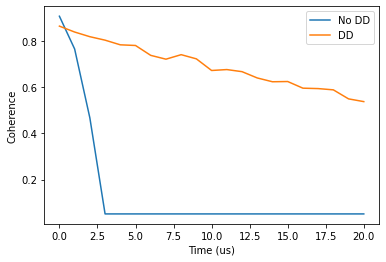

In [34]:
result1 = job1.result()
pop_counts1, mqc_counts1 = ghz_hanoi1.counts_from_result(result1)
Y1 = list(ghz_hanoi1.calc_coh(mqc_counts1).values())
Y1 = lim_array(Y1)

result2 = job2.result()
pop_counts2, mqc_counts2 = ghz_hanoi2.counts_from_result(result2)
Y2 = list(ghz_hanoi2.calc_coh(mqc_counts2).values())


X = np.array(delays_ns)/1000

plt.plot(X, Y1, label='No DD')
plt.plot(X, Y2, label='DD')
plt.xlabel('Time (us)')
plt.ylabel('Coherence')
plt.legend()

## GHZ Time Dependence Plots

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from ghzstate import GHZState
from utilities import startup, run_cal, load_cal
provider = startup()

Account already enabled
Provider: ibm-q-melbourne


In [168]:
def plot_from_job(ghzstate, job_list):
    pass
    
def plot_mqc(ghzstate, mqc_counts):
    gpop = []
    for counts in mqc_counts:
        gpop.append(counts['0'*ghzstate.ghz_size]/ghzstate.shots)
        
    plt.plot(ghzstate.delays[:-1], gpop)
    plt.ylim(0, 1)
        
    return gpop

def calc_fidelities(ghzstate, job_list, cal=None, apply_mit=False):
    ghzstate.load_cal(cal)
    f_list = []
    p_list = []
    c_list = []

    for job in job_list:
        pop_counts, mqc_counts = ghzstate.counts_from_result(job.result())
        if apply_mit is True:
            pop_counts_mit, mqc_counts_mit = ghzstate.mitigate_counts(pop_counts, mqc_counts)
            f, p, c = ghzstate.calc_fidelity(pop_counts_mit, mqc_counts_mit)
        else:
            f, p, c = ghzstate.calc_fidelity(pop_counts, mqc_counts)
        
        f_list.append(f)
        p_list.append(p)
        c_list.append(c)

    f_mean = dict.fromkeys(f, [])
    p_mean = dict.fromkeys(p, [])
    c_mean = dict.fromkeys(c, [])

    for t in f_mean.keys():
        rangei = range(len(f_list))
        f_mean[t] = [f_list[i][t] for i in rangei]
        p_mean[t] = [p_list[i][t] for i in rangei]
        c_mean[t] = [c_list[i][t] for i in rangei]

    for t in f_mean.keys():
        f_mean[t] = calc_mean(f_mean[t])
        p_mean[t] = calc_mean(p_mean[t])
        c_mean[t] = calc_mean(c_mean[t])
        
    f_mean_array = np.array(list(f_mean.values()))
    f_mean = (f_mean_array[:, 0].tolist(), f_mean_array[:, 1].tolist())
    p_mean_array = np.array(list(p_mean.values()))
    p_mean = (p_mean_array[:, 0].tolist(), p_mean_array[:, 1].tolist())
    c_mean_array = np.array(list(c_mean.values()))
    c_mean = (c_mean_array[:, 0].tolist(), c_mean_array[:, 1].tolist())
        
    return f_mean, p_mean, c_mean

def calc_mean(array):
    mean = np.mean(array)
    hrange = (max(array) - min(array))/2
    std = np.std(array)
    return mean, std
    

def plot_fidelities(ghzstate, means, delays, mode='f'):
    fig, ax = plt.subplots()
    f_mean, p_mean, c_mean = means
    
    X = delays
    Y0 = f_mean[0].copy()
    Y0err = f_mean[1].copy()
    Y1 = p_mean[0].copy()
    Y1err = p_mean[1].copy()
    Y2 = c_mean[0].copy()
    Y2err = c_mean[1].copy()
        
    if mode == 'f':
        ax.errorbar(X, Y0, yerr=Y0err, capsize=3, ls='dashed')
    elif mode == 'p':
        ax.errorbar(X, Y1, yerr=Y1err, capsize=3, ls='dashed')
    elif mode == 'c':
        ax.errorbar(X, Y2, yerr=Y2err, capsize=3, ls='dashed')

## ibmq_mumbai

In [5]:
backend = provider.get_backend('ibm_hanoi')
shots = 4096

#### N = 3

In [153]:
ghzdelay3 = GHZState(backend)
ghz_circ3, initial_layout3 = ghzdelay3.gen_ghz_circuit(3, 12)
delays_ns = list(range(0, 50000, 2500))
delays = ghzdelay3.format_delays(delays_ns, unit='ns')
delays_ms = [t/1000 for t in delays_ns]
circuits3 = ghzdelay3.gen_fid_circuits(delays, dynamic_decoupling=False)
print("Number of circuits:", len(circuits3))
print("Layout:", initial_layout3)

Number of circuits: 180
Layout: [12, 13, 14]


In [154]:
job3_0 = ghzdelay3.run_circuits(shots=shots)
job3_1 = ghzdelay3.run_circuits(shots=shots)
job3_2 = ghzdelay3.run_circuits(shots=shots)
job3_3 = ghzdelay3.run_circuits(shots=shots)
job3_4 = ghzdelay3.run_circuits(shots=shots)

cal = run_cal(backend, filename='calibrations/ghzdelay3_cal')

Job ID: 6344aec434425f0d57ca42ab
Job ID: 6344aec90a4a0c3874d01b5f
Job ID: 6344aecd4bc4b8e68e9ea492
Job ID: 6344aed16c7c4897a66bd397
Job ID: 6344aed534425f12b5ca42ac


In [157]:
job3_0 = backend.retrieve_job('6342d707cbdc4df44dc0eda1')
job3_1 = backend.retrieve_job('6342d70e4bc4b87bfd9e9fdc')
job3_2 = backend.retrieve_job('6342d71734425f4a1dca3ddf')
job3_3 = backend.retrieve_job('6342d71f0a4a0ca114d0163f')
job3_4 = backend.retrieve_job('6342d726d31ce7126ed80a6a')

cal = load_cal(filename='calibrations/ghzdelay3_cal')

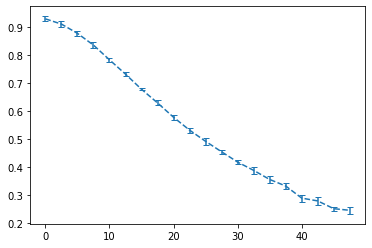

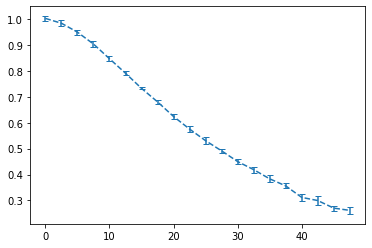

In [158]:
job_list = [job3_0, job3_1, job3_2, job3_3, job3_4]
means3 = calc_fidelities(ghzdelay3, job_list, cal=cal, apply_mit=False)
means_mit3 = calc_fidelities(ghzdelay3, job_list, cal=cal, apply_mit=True)

plot_fidelities(ghzdelay3, means3, delays_ms, mode='c')
plot_fidelities(ghzdelay3, means_mit3, delays_ms, mode='c')

#### N = 5

In [138]:
ghzdelay5 = GHZState(backend)
ghz_circ5, initial_layout5 = ghzdelay5.gen_ghz_circuit(5, 12)
delays_ns = list(range(0, 45000, 2500))
delays = ghzdelay5.format_delays(delays_ns, unit='ns')
delays_ms = [t/1000 for t in delays_ns]
circuits5 = ghzdelay5.gen_fid_circuits(delays, dynamic_decoupling=False)
print("Number of circuits:", len(circuits5))
print("Layout:", initial_layout5)

Number of circuits: 234
Layout: [12, 13, 14, 10, 7]


In [36]:
job5_0 = ghzdelay5.run_circuits(shots=shots)
job5_1 = ghzdelay5.run_circuits(shots=shots)
job5_2 = ghzdelay5.run_circuits(shots=shots)
job5_3 = ghzdelay5.run_circuits(shots=shots)
job5_4 = ghzdelay5.run_circuits(shots=shots)

cal = run_cal(backend, filename='calibrations/ghzdelay5_cal')

Job ID: 634312f6d31ce7cc32d80afc
Job ID: 634312fcea97bac269e17cd3
Job ID: 634313016c7c48a8696bcf37
Job ID: 634313070a4a0c48d3d016e0
Job ID: 6343130cd41d5e379dd31360


In [10]:
job5_0 = backend.retrieve_job('634312f6d31ce7cc32d80afc')
job5_1 = backend.retrieve_job('634312fcea97bac269e17cd3')
job5_2 = backend.retrieve_job('634313016c7c48a8696bcf37')
job5_3 = backend.retrieve_job('634313070a4a0c48d3d016e0')
job5_4 = backend.retrieve_job('6343130cd41d5e379dd31360')

cal = load_cal(filename='calibrations/ghzdelay5_cal')

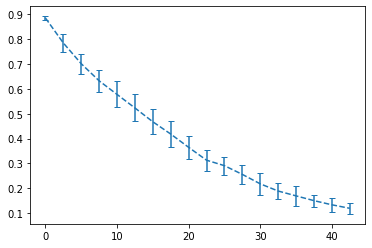

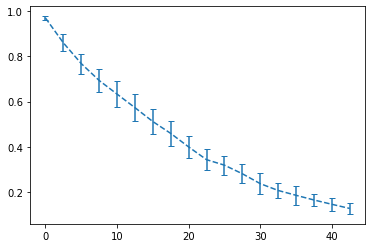

In [139]:
job_list = [job5_0, job5_1, job5_2, job5_3, job5_4]
means5 = calc_fidelities(ghzdelay5, job_list, cal=cal, apply_mit=False)
means_mit5 = calc_fidelities(ghzdelay5, job_list, cal=cal, apply_mit=True)

plot_fidelities(ghzdelay5, means5, delays_ms, mode='c')
plot_fidelities(ghzdelay5, means_mit5, delays_ms, mode='c')

#### N = 7

In [140]:
ghzdelay7 = GHZState(backend)
ghz_circ7, initial_layout7 = ghzdelay7.gen_ghz_circuit(7, 12)
delays_ns = list(range(0, 40000, 2500))
delays = ghzdelay7.format_delays(delays_ns, unit='ns')
delays_ms = [t/1000 for t in delays_ns]
circuits7 = ghzdelay7.gen_fid_circuits(delays, dynamic_decoupling=False)
print("Number of circuits:", len(circuits7))
print("Layout:", initial_layout7)

Number of circuits: 272
Layout: [12, 13, 14, 10, 7, 15, 11]


In [39]:
job7_0 = ghzdelay7.run_circuits(shots=shots)
job7_1 = ghzdelay7.run_circuits(shots=shots)
job7_2 = ghzdelay7.run_circuits(shots=shots)
job7_3 = ghzdelay7.run_circuits(shots=shots)
job7_4 = ghzdelay7.run_circuits(shots=shots)

cal = run_cal(backend, filename='calibrations/ghzdelay7_cal')

Job ID: 63432a536c7c4817de6bcf73
Job ID: 63432a5ad41d5eabd1d3139d
Job ID: 63432a630a4a0c8311d01721
Job ID: 63432a69d31ce729aed80b45
Job ID: 63432a70cbdc4d86c2c0ee76


In [13]:
job7_0 = backend.retrieve_job('63432a536c7c4817de6bcf73')
job7_1 = backend.retrieve_job('63432a5ad41d5eabd1d3139d')
job7_2 = backend.retrieve_job('63432a630a4a0c8311d01721')
job7_3 = backend.retrieve_job('63432a69d31ce729aed80b45')
job7_4 = backend.retrieve_job('63432a70cbdc4d86c2c0ee76')

cal = load_cal(filename='calibrations/ghzdelay7_cal')

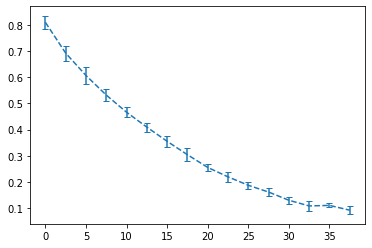

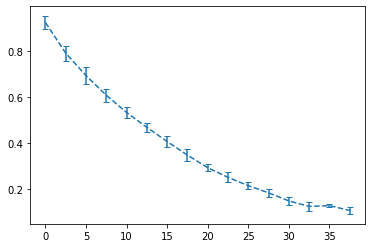

In [141]:
job_list = [job7_0, job7_1, job7_2, job7_3, job7_4]
means7 = calc_fidelities(ghzdelay7, job_list, cal=cal, apply_mit=False)
means_mit7 = calc_fidelities(ghzdelay7, job_list, cal=cal, apply_mit=True)

plot_fidelities(ghzdelay7, means7, delays_ms, mode='c')
plot_fidelities(ghzdelay7, means_mit7, delays_ms, mode='c')

#### N = 9

In [142]:
ghzdelay9 = GHZState(backend)
ghz_circ9, initial_layout9 = ghzdelay9.gen_ghz_circuit(9, 12)
delays_ns = list(range(0, 35000, 2500))
delays = ghzdelay9.format_delays(delays_ns, unit='ns')
delays_ms = [t/1000 for t in delays_ns]
circuits9 = ghzdelay9.gen_fid_circuits(delays, dynamic_decoupling=False)
print("Number of circuits:", len(circuits9))
print("Layout:", initial_layout9)

Number of circuits: 294
Layout: [12, 13, 14, 10, 7, 15, 11, 18, 8]


In [72]:
job9_0 = ghzdelay9.run_circuits(shots=shots)
job9_1 = ghzdelay9.run_circuits(shots=shots)
job9_2 = ghzdelay9.run_circuits(shots=shots)
job9_3 = ghzdelay9.run_circuits(shots=shots)
job9_4 = ghzdelay9.run_circuits(shots=shots)

cal = run_cal(backend, filename='calibrations/ghzdelay9_cal')

Job ID: 6343ee1768409f77f92c5426
Job ID: 6343ee216c7c482cce6bd160
Job ID: 6343ee2b6c7c4841c96bd162
Job ID: 6343ee3234425f39d3ca40ab
Job ID: 6343ee3daa9d8ff66e54df7c


In [ ]:
job9_0 = backend.retrieve_job('6343ee1768409f77f92c5426')
job9_1 = backend.retrieve_job('6343ee216c7c482cce6bd160')
job9_2 = backend.retrieve_job('6343ee2b6c7c4841c96bd162')
job9_3 = backend.retrieve_job('6343ee3234425f39d3ca40ab')
job9_4 = backend.retrieve_job('6343ee3daa9d8ff66e54df7c')
#job9_0 = backend.retrieve_job('6343425c34425f148dca3f06')
#job9_1 = backend.retrieve_job('63434263cbdc4d4a51c0eebd')
#job9_2 = backend.retrieve_job('6343426bd31ce788ded80b8c')
#job9_3 = backend.retrieve_job('6343427434425f0069ca3f07')
#job9_4 = backend.retrieve_job('6343427cea97ba5e32e17d52')

cal = load_cal(filename='calibrations/ghzdelay9_cal')

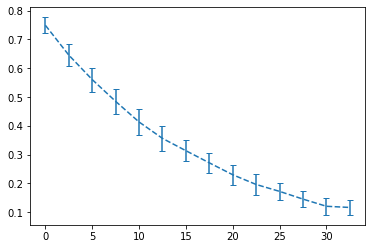

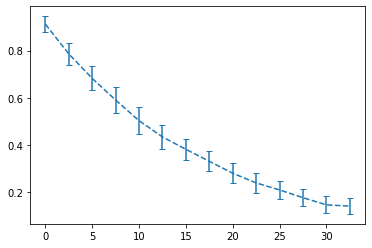

In [143]:
job_list = [job9_0, job9_1, job9_2, job9_3, job9_4]
means9 = calc_fidelities(ghzdelay9, job_list, cal=cal, apply_mit=False)
means_mit9 = calc_fidelities(ghzdelay9, job_list, cal=cal, apply_mit=True)

plot_fidelities(ghzdelay9, means9, delays_ms, mode='c')
plot_fidelities(ghzdelay9, means_mit9, delays_ms, mode='c')

#### N = 11

In [144]:
ghzdelay11 = GHZState(backend)
ghz_circ11, initial_layout11 = ghzdelay11.gen_ghz_circuit(11, 12)
delays_ns = list(range(0, 30000, 2500))
delays = ghzdelay11.format_delays(delays_ns, unit='ns')
delays_ms = [t/1000 for t in delays_ns]
circuits11 = ghzdelay11.gen_fid_circuits(delays, dynamic_decoupling=False)
print("Number of circuits:", len(circuits11))
print("Layout:", initial_layout11)

Number of circuits: 300
Layout: [12, 13, 14, 10, 7, 15, 11, 18, 8, 16, 4]


In [45]:
job11_0 = ghzdelay11.run_circuits(shots=shots)
job11_1 = ghzdelay11.run_circuits(shots=shots)
job11_2 = ghzdelay11.run_circuits(shots=shots)
job11_3 = ghzdelay11.run_circuits(shots=shots)
job11_4 = ghzdelay11.run_circuits(shots=shots)

cal = run_cal(backend, filename='calibrations/ghzdelay11_cal')

Job ID: 63435afcd41d5e53ddd3142c
Job ID: 63435b05ea97baef36e17da7
Job ID: 63435b110a4a0cb4b0d017aa
Job ID: 63435b1aea97ba2457e17da8
Job ID: 63435b226c7c4844926bd007


In [19]:
job11_0 = backend.retrieve_job('63435afcd41d5e53ddd3142c')
job11_1 = backend.retrieve_job('63435b05ea97baef36e17da7')
job11_2 = backend.retrieve_job('63435b110a4a0cb4b0d017aa')
job11_3 = backend.retrieve_job('63435b1aea97ba2457e17da8')
job11_4 = backend.retrieve_job('63435b226c7c4844926bd007')

cal = load_cal(filename='calibrations/ghzdelay11_cal')

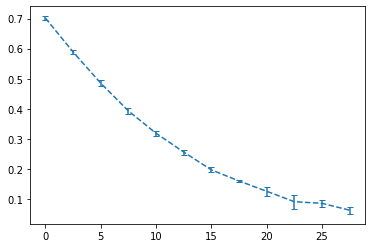

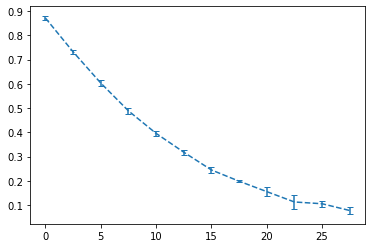

In [145]:
job_list = [job11_0, job11_1, job11_2, job11_3, job11_4]
means11 = calc_fidelities(ghzdelay11, job_list, cal=cal, apply_mit=False)
means_mit11 = calc_fidelities(ghzdelay11, job_list, cal=cal, apply_mit=True)

plot_fidelities(ghzdelay11, means11, delays_ms, mode='c')
plot_fidelities(ghzdelay11, means_mit11, delays_ms, mode='c')

#### N = 13

In [146]:
ghzdelay13 = GHZState(backend)
ghz_circ13, initial_layout13 = ghzdelay13.gen_ghz_circuit(13, 12)
delays_ns = list(range(0, 25000, 2500))
delays = ghzdelay13.format_delays(delays_ns, unit='ns')
delays_ms = [t/1000 for t in delays_ns]
circuits13 = ghzdelay13.gen_fid_circuits(delays, dynamic_decoupling=False)
print("Number of circuits:", len(circuits13))
print("Layout:", initial_layout13)

Number of circuits: 290
Layout: [12, 13, 14, 10, 7, 15, 11, 18, 8, 16, 4, 19, 1]


In [48]:
job13_0 = ghzdelay13.run_circuits(shots=shots)
job13_1 = ghzdelay13.run_circuits(shots=shots)
job13_2 = ghzdelay13.run_circuits(shots=shots)
job13_3 = ghzdelay13.run_circuits(shots=shots)
job13_4 = ghzdelay13.run_circuits(shots=shots)

cal = run_cal(backend, filename='calibrations/ghzdelay13_cal')

Job ID: 634364b74bc4b856b39ea143
Job ID: 634364c434425f2206ca3f60
Job ID: 634364cdea97ba6e7ce17dc1
Job ID: 634364d5ea97ba4313e17dc2
Job ID: 634364e0d31ce7f4aed80bf5


In [22]:
job13_0 = backend.retrieve_job('634364b74bc4b856b39ea143')
job13_1 = backend.retrieve_job('634364c434425f2206ca3f60')
job13_2 = backend.retrieve_job('634364cdea97ba6e7ce17dc1')
job13_3 = backend.retrieve_job('634364d5ea97ba4313e17dc2')
job13_4 = backend.retrieve_job('634364e0d31ce7f4aed80bf5')

cal = load_cal(filename='calibrations/ghzdelay13_cal')

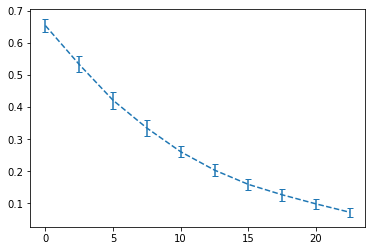

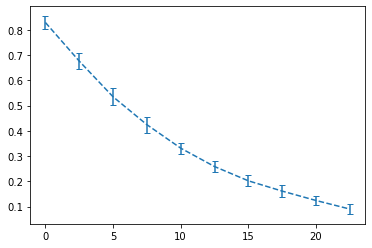

In [147]:
job_list = [job13_0, job13_1, job13_2, job13_3, job13_4]
means13 = calc_fidelities(ghzdelay13, job_list, cal=cal, apply_mit=False)
means_mit13 = calc_fidelities(ghzdelay13, job_list, cal=cal, apply_mit=True)

plot_fidelities(ghzdelay13, means13, delays_ms, mode='c')
plot_fidelities(ghzdelay13, means_mit13, delays_ms, mode='c')

#### N = 15

In [148]:
ghzdelay15 = GHZState(backend)
ghz_circ15, initial_layout15 = ghzdelay15.gen_ghz_circuit(15, 12)
delays_ns = list(range(0, 22500, 2500))
delays = ghzdelay15.format_delays(delays_ns, unit='ns')
delays_ms = [t/1000 for t in delays_ns]
circuits15 = ghzdelay15.gen_fid_circuits(delays, dynamic_decoupling=False)
print("Number of circuits:", len(circuits15))
print("Layout:", initial_layout15)

Number of circuits: 297
Layout: [12, 13, 14, 10, 7, 15, 11, 18, 8, 16, 4, 19, 1, 21, 5]


In [51]:
job15_0 = ghzdelay15.run_circuits(shots=shots)
job15_1 = ghzdelay15.run_circuits(shots=shots)
job15_2 = ghzdelay15.run_circuits(shots=shots)
job15_3 = ghzdelay15.run_circuits(shots=shots)
job15_4 = ghzdelay15.run_circuits(shots=shots)

cal = run_cal(backend, filename='calibrations/ghzdelay15_cal')

Job ID: 63436d71d41d5edac0d3145a
Job ID: 63436d7c34425ff0eeca3f78
Job ID: 63436d85d41d5e9406d3145b
Job ID: 63436d8fd31ce77626d80c05
Job ID: 63436d9b4bc4b868619ea158


In [25]:
job15_0 = backend.retrieve_job('63436d71d41d5edac0d3145a')
job15_1 = backend.retrieve_job('63436d7c34425ff0eeca3f78')
job15_2 = backend.retrieve_job('63436d85d41d5e9406d3145b')
job15_3 = backend.retrieve_job('63436d8fd31ce77626d80c05')
job15_4 = backend.retrieve_job('63436d9b4bc4b868619ea158')

cal = load_cal(filename='calibrations/ghzdelay15_cal')

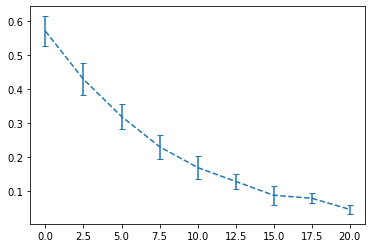

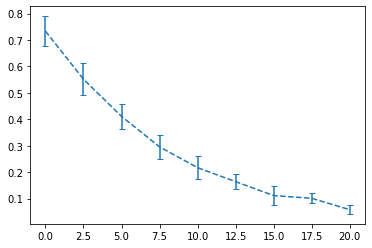

In [149]:
job_list = [job15_0, job15_1, job15_2, job15_3, job15_4]
means15 = calc_fidelities(ghzdelay15, job_list, cal=cal, apply_mit=False)
means_mit15 =  calc_fidelities(ghzdelay15, job_list, cal=cal, apply_mit=True)

plot_fidelities(ghzdelay15, means15, delays_ms, mode='c')
plot_fidelities(ghzdelay15, means_mit15, delays_ms, mode='c')

## Final Plots

#### Coherence Decays

In [309]:
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [357]:
def decay(t, a, b):
    return a * np.exp(-b * t)

def fit_decay(means, delays=np.arange(0, 100, 2.5)):
    Y = means[2][0]
    Yerr = means[2][1]
    X = delays[:len(Y)]
    
    #popt, pcov = curve_fit(decay, X, Y)
    popt, pcov = curve_fit(decay, X, Y, sigma=Yerr, absolute_sigma=True)
    Xfit = np.linspace(X[0], X[-1], 100)
    Yfit = decay(Xfit, *popt)
    
    print(f'a = {popt[0]}, b = {popt[1]}')
    
    return (X, Y, Yerr), (Xfit, Yfit), popt, pcov

def normalise(Y, Yerr, Yfit):
    Yn = [0] * len(Y)
    Ynerr = [0] * len(Y)
    y0 = Y[0]
    Ynfit = Yfit/y0
    for i in range(len(Y)):
        Yn[i] = Y[i]/y0
        Ynerr[i] = Yerr[i]/y0
        
    return Yn, Ynerr, Ynfit

In [358]:
(X3, Y3, Y3err), (X3fit, Y3fit), (a3, b3), pcov3 = fit_decay(means_mit3)
(X5, Y5, Y5err), (X5fit, Y5fit), (a5, b5), pcov5 = fit_decay(means_mit5)
(X7, Y7, Y7err), (X7fit, Y7fit), (a7, b7), pcov7 = fit_decay(means_mit7)
(X9, Y9, Y9err), (X9fit, Y9fit), (a9, b9), pcov9 = fit_decay(means_mit9)
(X11, Y11, Y11err), (X11fit, Y11fit), (a11, b11), pcov11 = fit_decay(means_mit11)
(X13, Y13, Y13err), (X13fit, Y13fit), (a13, b13), pcov13 = fit_decay(means_mit13)
(X15, Y15, Y15err), (X15fit, Y15fit), (a15, b15), pcov15 = fit_decay(means_mit15)

Y3n, Y3nerr, Y3nfit = normalise(Y3, Y3err, Y3fit)
Y5n, Y5nerr, Y5nfit = normalise(Y5, Y5err, Y5fit)
Y7n, Y7nerr, Y7nfit = normalise(Y7, Y7err, Y7fit)
Y9n, Y9nerr, Y9nfit = normalise(Y9, Y9err, Y9fit)
Y11n, Y11nerr, Y11nfit = normalise(Y11, Y11err, Y11fit)
Y13n, Y13nerr, Y13nfit = normalise(Y13, Y13err, Y13fit)
Y15n, Y15nerr, Y15nfit = normalise(Y15, Y15err, Y15fit)

a = 1.0815352474522983, b = 0.027853450070583336
a = 0.9702385154093985, b = 0.04605630844713841
a = 0.930629774173301, b = 0.05762538202262839
a = 0.9121791646611828, b = 0.05885352268124692
a = 0.8863158560504306, b = 0.0843433334370494
a = 0.8399032232799237, b = 0.09419307072609046
a = 0.739715413922769, b = 0.12111787756552272


In [439]:
plt.rc('font', size=13)
figsize = (7.5, 5)

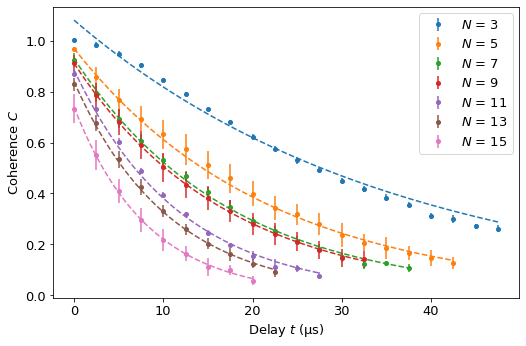

In [440]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(figsize=figsize)

ax.errorbar(X3, Y3, yerr=Y3err, marker='o', markersize=4, ls='', color=colors[0], label='$\it{N}$ = 3')
ax.plot(X3fit, Y3fit, ls='--', color=colors[0])

ax.errorbar(X5, Y5, yerr=Y5err, marker='o', markersize=4, ls='', color=colors[1], label='$\it{N}$ = 5')
ax.plot(X5fit, Y5fit, ls='--', color=colors[1])

ax.errorbar(X7, Y7, yerr=Y7err, marker='o', markersize=4, ls='', color=colors[2], label='$\it{N}$ = 7')
ax.plot(X7fit, Y7fit, ls='--', color=colors[2])

ax.errorbar(X9, Y9, yerr=Y9err, marker='o', markersize=4, ls='', color=colors[3], label='$\it{N}$ = 9')
ax.plot(X9fit, Y9fit, ls='--', color=colors[3])

ax.errorbar(X11, Y11, yerr=Y11err, marker='o', markersize=4, ls='', color=colors[4], label='$\it{N}$ = 11')
ax.plot(X11fit, Y11fit, ls='--', color=colors[4])

ax.errorbar(X13, Y13, yerr=Y13err, marker='o', markersize=4, ls='', color=colors[5], label='$\it{N}$ = 13')
ax.plot(X13fit, Y13fit, ls='--', color=colors[5])

ax.errorbar(X15, Y15, yerr=Y15err, marker='o', markersize=4, ls='', color=colors[6], label='$\it{N}$ = 15')
ax.plot(X15fit, Y15fit, ls='--', color=colors[6])

ax.set_xlabel('Delay $\it{t}$ (μs)')
ax.set_ylabel('Coherence $\it{C}$')
ax.legend()

fig.set_tight_layout(True)
fig.savefig('output/ndecay', dpi=300)

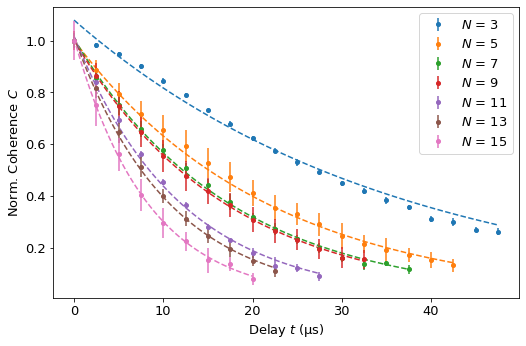

In [441]:
fig, ax = plt.subplots(figsize=figsize)

ax.errorbar(X3, Y3n, yerr=Y3nerr, marker='o', markersize=4, ls='', color=colors[0], label='$\it{N}$ = 3')
ax.plot(X3fit, Y3nfit, ls='--', color=colors[0])

ax.errorbar(X5, Y5n, yerr=Y5nerr, marker='o', markersize=4, ls='', color=colors[1], label='$\it{N}$ = 5')
ax.plot(X5fit, Y5nfit, ls='--', color=colors[1])

ax.errorbar(X7, Y7n, yerr=Y7nerr, marker='o', markersize=4, ls='', color=colors[2], label='$\it{N}$ = 7')
ax.plot(X7fit, Y7nfit, ls='--', color=colors[2])

ax.errorbar(X9, Y9n, yerr=Y9nerr, marker='o', markersize=4, ls='', color=colors[3], label='$\it{N}$ = 9')
ax.plot(X9fit, Y9nfit, ls='--', color=colors[3])

ax.errorbar(X11, Y11n, yerr=Y11nerr, marker='o', markersize=4, ls='', color=colors[4], label='$\it{N}$ = 11')
ax.plot(X11fit, Y11nfit, ls='--', color=colors[4])

ax.errorbar(X13, Y13n, yerr=Y13nerr, marker='o', markersize=4, ls='', color=colors[5], label='$\it{N}$ = 13')
ax.plot(X13fit, Y13nfit, ls='--', color=colors[5])

ax.errorbar(X15, Y15n, yerr=Y15nerr, marker='o', markersize=4, ls='', color=colors[6], label='$\it{N}$ = 15')
ax.plot(X15fit, Y15nfit, ls='--', color=colors[6])

ax.set_xlabel('Delay $\it{t}$ (μs)')
ax.set_ylabel('Norm. Coherence $\it{C}$')
ax.legend()

fig.set_tight_layout(True)
fig.savefig('output/ndecaynorm', dpi=300)

### 

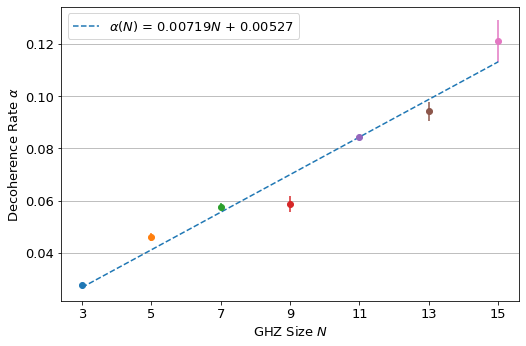

In [442]:
fig, ax = plt.subplots(figsize=figsize)

X = [3, 5, 7, 9, 11, 13, 15]
B = [b3, b5, b7, b9, b11, b13, b15]
P = [pcov3, pcov5, pcov7, pcov9, pcov11, pcov13, pcov15]
Berr = [np.sqrt(np.diag(pcov))[1] for pcov in P]
slope, intercept, r, p, se = linregress(X, B)

for i, N in enumerate(X):
    ax.errorbar(N, B[i], Berr[i], marker='o', ls=' ', color=colors[i])
#ax.errorbar(X, B, yerr=Berr, marker='o', ls=' ')
ax.set_xticks([3, 5, 7, 9, 11, 13, 15])
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
Xfit = np.linspace(3, 15, 100)
label = '$\it{α(N)}$ = ' + f'{slope:.5f}' + '$\it{N}$ + ' + f'{intercept:.5f}'
ax.plot(Xfit, Xfit * slope + intercept, ls='--', label=label)

ax.set_xlabel('GHZ Size $\it{N}$')
ax.set_ylabel('Decoherence Rate $\it{α}$')
ax.legend(loc='upper left')
ax.grid(axis='y')

fig.set_tight_layout(True)
fig.savefig('output/decoherencescaling', dpi=300)

## Misc

#### hanoi N = 3

In [ ]:
backend = provider.get_backend('ibm_hanoi')
hanoi = GHZState(backend)
delays_ns = list(range(0, 18600, 600))
delays_ms = [t/1000 for t in delays_ns]
delays = hanoi.format_delays(delays_ns, unit='ns')

In [266]:
hanoi3 = GHZState(backend)
ghz_circ3, initial_layout3 = hanoi3.gen_ghz_circuit(3, 12)
circuits3 = hanoi3.gen_fid_circuits(delays, dynamic_decoupling=False)

In [267]:
len(circuits3)

279

In [80]:
job3_0 = hanoi3.run_circuits()
job3_1 = hanoi3.run_circuits()
job3_2 = hanoi3.run_circuits()
job3_3 = hanoi3.run_circuits()
job3_4 = hanoi3.run_circuits()

cal = run_cal(backend, filename='calibrations/hanoi3_cal')

Job ID: 6339432edee3d6e48bb915b3
Job ID: 63394331dee3d642e3b915b4
Job ID: 63394334b7c9eb8c36c92533
Job ID: 6339433683172d5ba7d1845f
Job ID: 633943396040897f638e1873


In [8]:
job3_0 = backend.retrieve_job('6339432edee3d6e48bb915b3')
job3_1 = backend.retrieve_job('63394331dee3d642e3b915b4')
job3_2 = backend.retrieve_job('63394334b7c9eb8c36c92533')
job3_3 = backend.retrieve_job('6339433683172d5ba7d1845f')
job3_4 = backend.retrieve_job('633943396040897f638e1873')
cal = load_cal(filename='calibrations/hanoi3_cal')

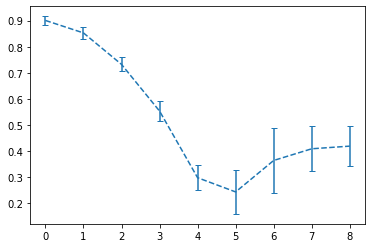

In [250]:
job_list = [job3_0, job3_1, job3_2, job3_3, job3_4]
means = calc_fidelities(hanoi3, job_list)

plot_fidelities(hanoi3, means, delays_ms, mode='c')

## Longer Duration

#### 7

In [84]:
mumbai7x = GHZState(backend)
ghz_circ7x, initial_layout7x = mumbai7x.gen_ghz_circuit(7, 12)
delays_ns = list(range(0, 40000, 2500))
delays = mumbai7x.format_delays(delays_ns, unit='ns')
delays_ms = [t/1000 for t in delays_ns]
circuits7x = mumbai7x.gen_fid_circuits(delays, dynamic_decoupling=False)
print("Number of circuits:", len(circuits7x))
print("Layout:", initial_layout7x)

Number of circuits: 272
Layout: [12, 10, 7, 15, 18, 13, 4]


In [85]:
job7x_0 = mumbai7x.run_circuits()
job7x_1 = mumbai7x.run_circuits()
job7x_2 = mumbai7x.run_circuits()
job7x_3 = mumbai7x.run_circuits()
job7x_4 = mumbai7x.run_circuits()
job7x_5 = mumbai7x.run_circuits()

cal = run_cal(backend, filename='calibrations/mumbai7x_cal')

Job ID: 633e6743a2769fe9c128bb0b
Job ID: 633e674d83172d63aed19850
Job ID: 633e6756dee3d67f29b92958
Job ID: 633e675e82966683bdd02199
Job ID: 633e6765007ac51c259e7c04
Job ID: 633e676e2728ec5615fb6baf


In [31]:
job7x_0 = backend.retrieve_job('')
job7x_1 = backend.retrieve_job('')
job7x_2 = backend.retrieve_job('')
job7x_3 = backend.retrieve_job('')
job7x_4 = backend.retrieve_job('')
job7x_5 = backend.retrieve_job('')

cal = load_cal(filename='calibrations/mumbai7x_cal')

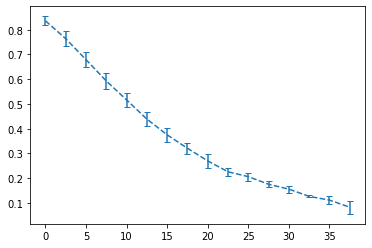

In [86]:
job_list = [job7x_0, job7x_1, job7x_2, job7x_3, job7x_4, job7x_5]
means = calc_fidelities(mumbai7x, job_list, cal=cal, apply_mit=False)
means_mit = calc_fidelities(mumbai7x, job_list, cal=cal, apply_mit=True)

plot_fidelities(mumbai7x, means, delays_ms, mode='c')

#### 15

In [94]:
mumbai15x = GHZState(backend)
ghz_circ15x, initial_layout15x = mumbai15x.gen_ghz_circuit(15, 12)
delays_ns = list(range(0, 27000, 3000))
delays = mumbai15x.format_delays(delays_ns, unit='ns')
delays_ms = [t/1000 for t in delays_ns]
circuits15x = mumbai15x.gen_fid_circuits(delays, dynamic_decoupling=False)
print("Number of circuits:", len(circuits15x))
print("Layout:", initial_layout15x)

Number of circuits: 297
Layout: [12, 10, 7, 15, 18, 13, 4, 14, 1, 21, 6, 11, 23, 2, 17]


In [92]:
job15x_0 = mumbai15x.run_circuits()
job15x_1 = mumbai15x.run_circuits()
job15x_2 = mumbai15x.run_circuits()
job15x_3 = mumbai15x.run_circuits()
job15x_4 = mumbai15x.run_circuits()
job15x_5 = mumbai15x.run_circuits()

cal = run_cal(backend, filename='calibrations/mumbai15x_cal')

Job ID: 633e99a08022eea2d79d1fe8
Job ID: 633e99ac8022ee2f6f9d1fe9
Job ID: 633e99b783172d8359d19964
Job ID: 633e99c7dee3d69aeeb92a3c
Job ID: 633e99d1e50d9f84b9105691
Job ID: 633e99dd83172d2eabd19967


In [95]:
# 2500
job15x_0 = backend.retrieve_job('633e879e83172d10c8d198fc')
job15x_1 = backend.retrieve_job('633e87aa83172d185bd198fd')
job15x_2 = backend.retrieve_job('633e87b583172d603ad198fe')
job15x_3 = backend.retrieve_job('633e87c0a2769f47bd28bbb2')
job15x_4 = backend.retrieve_job('633e87ca2728ec0133fb6c60')
job15x_5 = backend.retrieve_job('633e87d6007ac513039e7ca7')

cal = load_cal(filename='calibrations/mumbai15x_cal')

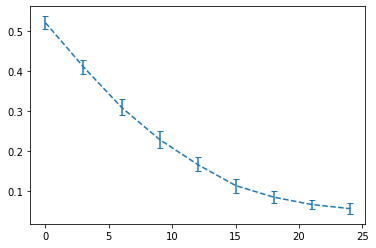

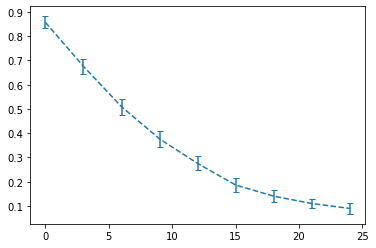

In [98]:
job_list = [job15x_0, job15x_1, job15x_2, job15x_3, job15x_4, job15x_5]
#means = calc_fidelities(mumbai15x, job_list, cal=cal, apply_mit=False)
#means_mit = calc_fidelities(mumbai15x, job_list, cal=cal, apply_mit=True)

plot_fidelities(mumbai15x, means, delays_ms, mode='c')
plot_fidelities(mumbai15x, means_mit, delays_ms, mode='c')